## E-Mail Spam Detection

**Tasks:**
- Build a spam classifier using Scikit-learn or XGBoost
- Evaluate the performance using accuracy, precision, recall, and F1-score
- Optimize the classifier by tuning hyperparameters such as the number of features and smoothing parameter
- Visualize the results using a confusion matrix and a classification report


### Data Exploration

We begin by exploring the dataset to understand the characteristics of the emails and any preprocessing requirements.

In [1]:
# Import necessary packages
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# go to parent directory
os.chdir("../")
%pwd

'c:\\Users\\DataScience\\Documents\\GitHub\\E-Mail_Spam_Detection'

In [8]:
# Read the dataset
df = pd.read_csv('db\emails_spam.csv')
df.head()

,spam,email
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


Let's inspect the overall data and get an initial feel for its structure and features.

In [9]:
# Examine the number of words and the character length of each email
df['text_length'] = df['email'].apply(len)
df['email_words'] = df['email'].str.split().apply(len)
df.head()

,spam,email,text_length,email_words
0,1,ounce feather bowl hummingbird opec moment ala...,148,20
1,1,wulvob get your medircations online qnb ikud v...,808,103
2,0,computer connection from cnn com wednesday es...,2235,337
3,1,university degree obtain a prosperous future m...,592,76
4,0,thanks for all your answers guys i know i shou...,1362,222


The emails appear to have been preprocessed (e.g., lowercased), which we'll assume for our analysis.

In [10]:
# Median text and word counts
print('Median text length:', df['text_length'].median())
print('Median word count:', df['email_words'].median())

Median text length: 866.0
Median word count: 151.0


In [11]:
# Check label balance
df['spam'].value_counts()

spam
1    15813
0    14187
Name: count, dtype: int64

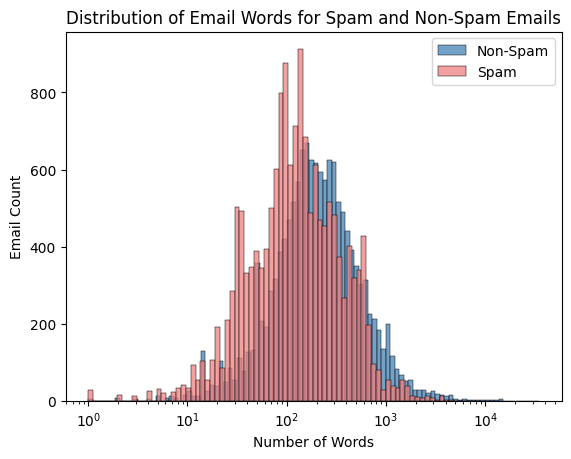

In [12]:
# Visualize word count distribution for spam vs. non-spam
sns.histplot(
    df[df["spam"] == 0]["email_words"],
    color="steelblue",
    label="Non-Spam",
    kde=False,
    log_scale=True,
)
sns.histplot(
    df[df["spam"] == 1]["email_words"],
    color="lightcoral",
    label="Spam",
    kde=False,
    log_scale=True,
)
plt.xlabel('Number of Words')
plt.ylabel('Email Count')
plt.title('Distribution of Email Words for Spam and Non-Spam Emails')
plt.legend()
plt.show()

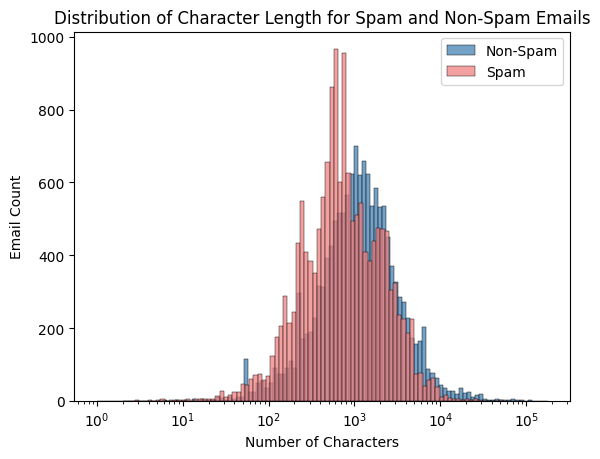

In [13]:
# Visualize character length distribution for spam vs. non-spam
sns.histplot(
    df[df["spam"] == 0]["text_length"],
    color="steelblue",
    label="Non-Spam",
    kde=False,
    log_scale=True,
)

sns.histplot(
    df[df["spam"] == 1]["text_length"],
    color="lightcoral",
    label="Spam",
    kde=False,
    log_scale=True,
)
plt.xlabel('Number of Characters')
plt.ylabel('Email Count')
plt.title('Distribution of Character Length for Spam and Non-Spam Emails')
plt.legend()
plt.show()

Spam emails tend to be shorter in both text length and word count compared to non-spam emails .

To further analyze word usage, let's visualize word frequencies using word clouds.

In [16]:
from wordcloud import WordCloud

all_words_spam = ' '.join(list(df[df['spam'] == 0]['email']))
all_words_not_spam = ' '.join(list(df[df['spam'] == 1]['email']))
wordcloud_spam = WordCloud(width=800, height=800, background_color='white').generate(all_words_spam)
wordcloud_not_spam = WordCloud(width=800, height=800, background_color='white').generate(all_words_not_spam)

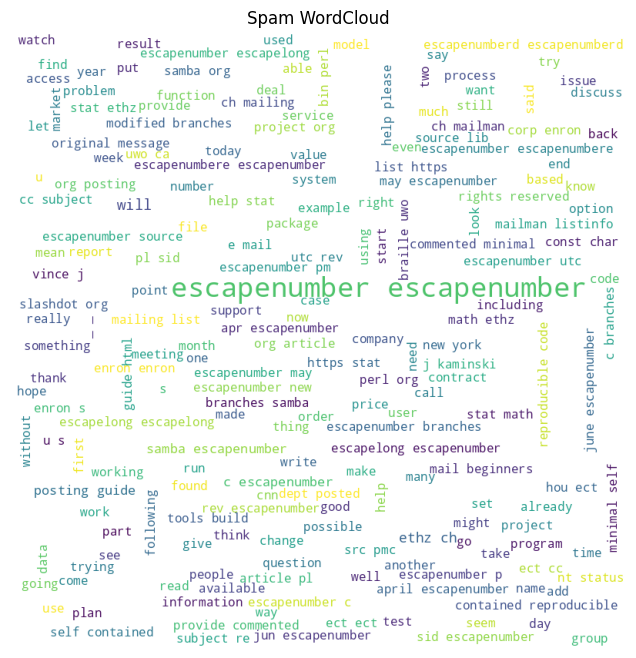

In [18]:
# Display Spam wordcloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_spam)
plt.axis('off')
plt.title('Spam WordCloud')
plt.show()

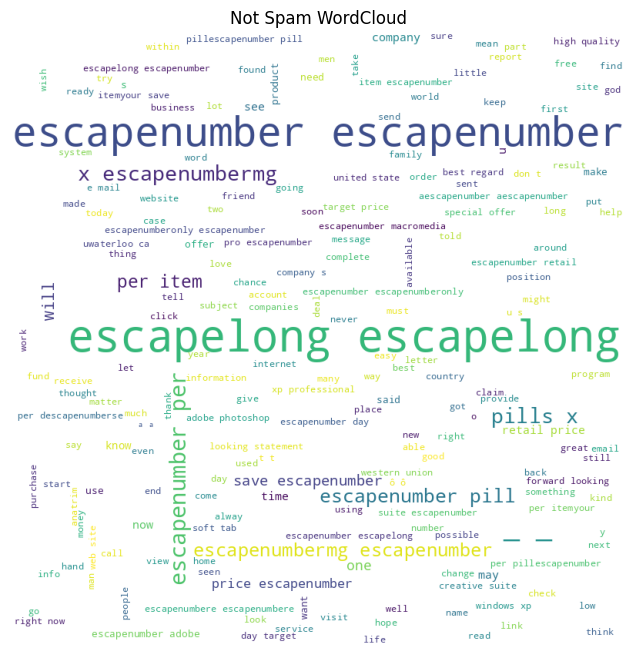

In [19]:
# Display Not Spam wordcloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_not_spam)
plt.axis('off')
plt.title('Not Spam WordCloud')
plt.show()

Some recurring strings (e.g., words containing 'escape') may represent special characters. We'll preprocess emails to remove these for clearer word cloud insights.

In [20]:
import re

def remove_sp(text):
    return re.sub(r'\b(?!escape\b)\w*escape\w*\b', '', re.sub(r'[^a-z\s]', '', text))

df['email_remove_sp'] = df['email'].apply(remove_sp)

#### WordCloud after Removing Special Characters

In [21]:
all_words_remove_sp_spam = ' '.join(list(df[df['spam'] == 0]['email_remove_sp']))
all_words_remove_sp_not_spam = ' '.join(list(df[df['spam'] == 1]['email_remove_sp']))
wordcloud_remove_sp_spam = WordCloud(width=800, height=800, background_color='white').generate(all_words_remove_sp_spam)
wordcloud_remove_sp_not_spam = WordCloud(width=800, height=800, background_color='white').generate(all_words_remove_sp_not_spam)

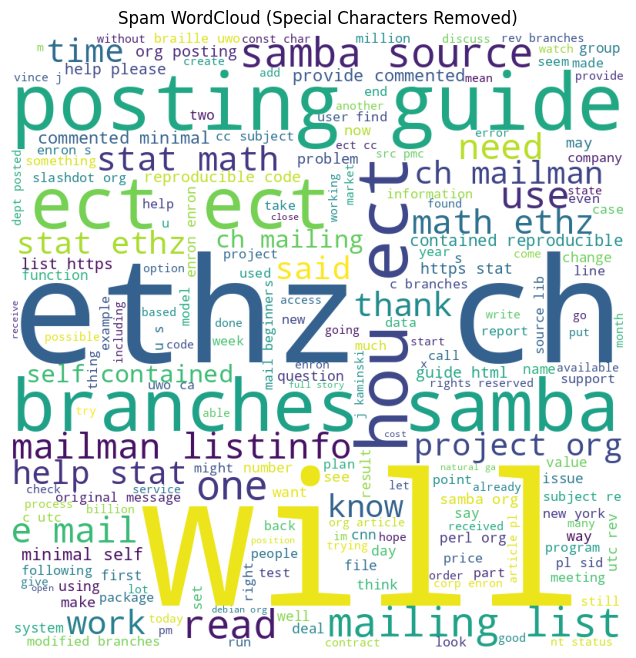

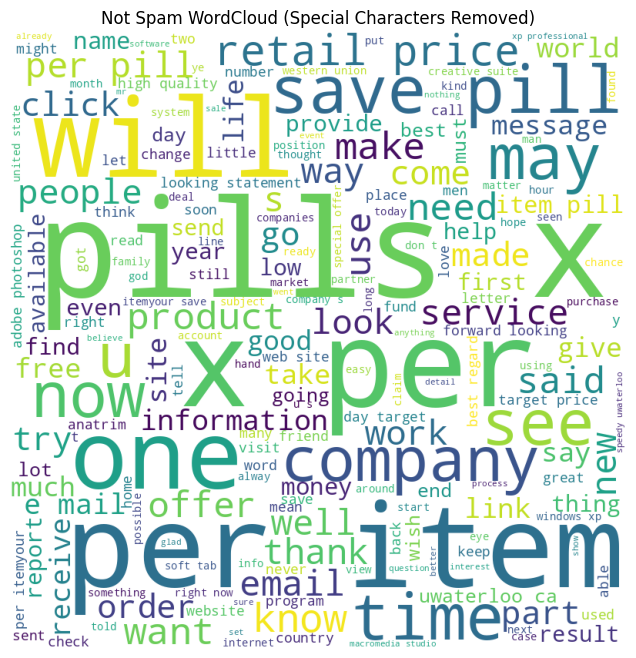

In [23]:
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_remove_sp_spam)
plt.axis('off')
plt.title('Spam WordCloud (Special Characters Removed)')
plt.show()
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_remove_sp_not_spam)
plt.axis('off')
plt.title('Not Spam WordCloud (Special Characters Removed)')
plt.show()

To further clarify the distinguishing words, we'll remove stopwords as well.

In [26]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DataScience\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DataScience\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DataScience\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DataScience\AppData\Roaming\nltk_data...


True

In [27]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

eng_stop_words = set(stopwords.words('english'))

def remove_stop(text):
    word_tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in word_tokens if word not in eng_stop_words])
    return filtered_text

df['email_remove_sp_stop'] = df['email_remove_sp'].apply(remove_stop)

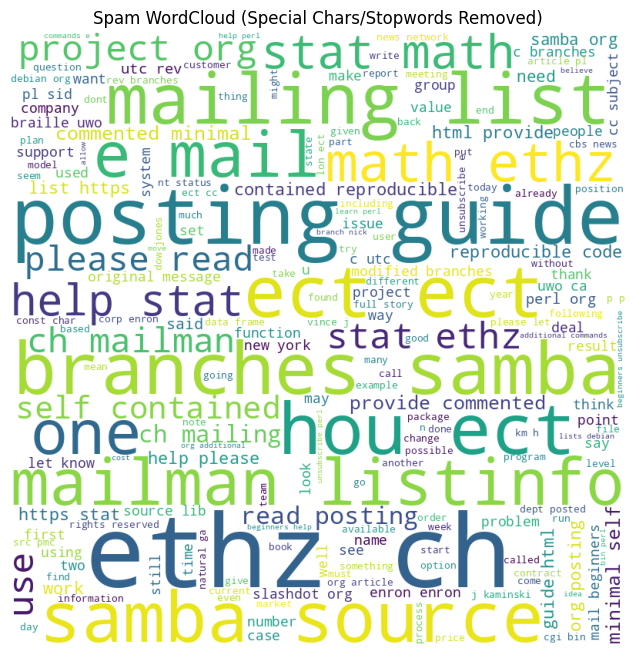

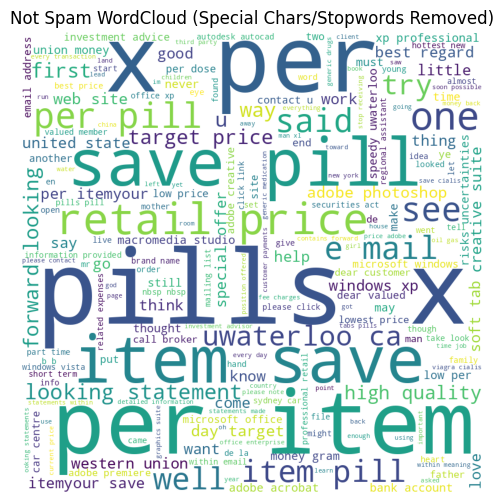

In [28]:
all_words_remove_sp_stop_spam = ' '.join(list(df[df['spam'] == 0]['email_remove_sp_stop']))
all_words_remove_sp_stop_not_spam = ' '.join(list(df[df['spam'] == 1]['email_remove_sp_stop']))

wordcloud_remove_sp_stop_spam = WordCloud(width=800, height=800, background_color='white').generate(all_words_remove_sp_stop_spam)
wordcloud_remove_sp_stop_not_spam = WordCloud(width=800, height=800, background_color='white').generate(all_words_remove_sp_stop_not_spam)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_remove_sp_stop_spam)
plt.axis('off')
plt.title('Spam WordCloud (Special Chars/Stopwords Removed)')
plt.show()
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud_remove_sp_stop_not_spam)
plt.axis('off')
plt.title('Not Spam WordCloud (Special Chars/Stopwords Removed)')
plt.show()

We observe clearer differences between classes. Notably, spam and not-spam emails tend to use distinct words, validating the feasibility of classifier modeling .

## Spam Classifier Modelling Experiments


We'll evaluate multiple models and text preprocessing strategies to determine the best approach for our dataset.

**Dataset variations to use:**
1. Original Data
2. Special characters removed
3. Special characters + stopwords removed
4. Special characters + stopwords removed, stemmed
5. Special characters + stopwords removed, lemmatized

**Text vectorization techniques:**
- Bag of Words (BoW)
- TF-IDF

**Models evaluated (using default parameters):**
- Naive Bayes
- Logistic Regression
- Support Vector Classifier (SVC)
- Random Forest
- XGBoost

**Evaluation strategy:**
- Train/test split (stratified)
- Cross-validation for performance stability
- Metrics: Accuracy, Precision, Recall, F1-Score
- *Precision* prioritized (to minimize false positives—important since a real email marked as spam is undesirable for business)
- Prefer simplest effective model with minimal preprocessing


In [29]:
# Stemming and Lemmatization
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_text(text):
    word_tokens = word_tokenize(text)
    stemmed_text = ' '.join([stemmer.stem(word) for word in word_tokens])
    return stemmed_text

def lemmatize_text(text):
    word_tokens = word_tokenize(text)
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])
    return lemmatized_text


In [30]:
# Create stemmed and lemmatized columns
df['email_remove_sp_stop_stem'] = df['email_remove_sp_stop'].apply(stem_text)
df['email_remove_sp_stop_lemm'] = df['email_remove_sp_stop'].apply(lemmatize_text)

In [33]:
# Split dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('spam', axis=1), df['spam'], test_size=0.2, stratify=df['spam'], random_state=42)

We'll log experiments using MLflow.

In [ ]:
import mlflow
EXPERIMENT_NAME = "NLP-Spam-Classifier-Experiment"
# Optionally: mlflow.create_experiment(EXPERIMENT_NAME)
current_experiment = dict(mlflow.get_experiment_by_name(EXPERIMENT_NAME))
experiment_id = current_experiment['experiment_id']

In [ ]:
import mlflow.data
from mlflow.data.pandas_dataset import PandasDataset
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def evaluate_models(train_data, train_labels, experiment_id):
    
    training_df = pd.concat([X_train['email'], y_train], axis =1).reset_index(drop = True)
    # Models to evaluate
    models = {
        "Naive Bayes": MultinomialNB(),
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    # Metrics
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1': make_scorer(f1_score)}

    # Vectorizations
    vectorizers = {
        "BoW": CountVectorizer(),
        "TF-IDF": TfidfVectorizer()
    }
    
    results = []
    for vect_name, vectorizer in vectorizers.items():
            X = vectorizer.fit_transform(train_data)

            for model_name, model in models.items():
                vect_mod_name = vect_name +'_'+model_name
                # Cross-Validate the model
                RUN_NAME = f"run_{vect_mod_name}"
                mlflow.end_run()
                with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME) as run:
                    # Retrieve run id
                    RUN_ID = run.info.run_id

                    cv_results = cross_validate(model, X, train_labels, scoring=['accuracy', 'precision', 'recall', 'f1'], cv=3, return_train_score=False)
                    for i in range(3):
                        iteration_result = {
                            'Iteration': i + 1,
                            'Model': model_name,
                            'Vectorizer': vect_name,
                            'Accuracy': cv_results['test_accuracy'][i],
                            'Precision': cv_results['test_precision'][i],
                            'Recall': cv_results['test_recall'][i],
                            'F1 Score': cv_results['test_f1'][i]
                        }
                        results.append(iteration_result)                       
                    # Calculating the metrics means
                    mean_result = {
                        'Iteration': 'Mean',
                        'Model': model_name,
                        'Vectorizer': vect_name,
                        'Accuracy': np.mean(cv_results['test_accuracy']),
                        'Precision': np.mean(cv_results['test_precision']),
                        'Recall': np.mean(cv_results['test_recall']),
                        'F1 Score': np.mean(cv_results['test_f1'])
                    }
                    results.append(mean_result)
                    
                    
                    # Track metrics
                    mlflow.log_metric(f"cv_3_{vect_mod_name}_accuracy", mean_result['Accuracy'])
                    mlflow.log_metric(f"cv_3_{vect_mod_name}_precision", mean_result['Precision'])
                    mlflow.log_metric(f"cv_3_{vect_mod_name}_recall", mean_result['Recall'])
                    mlflow.log_metric(f"cv_3_{vect_mod_name}_f1", mean_result['F1 Score'])
                    # Track model
                    model.fit(X, train_labels)
                    training_df["ModelOutput"] = model.predict(X)
                    dataset = mlflow.data.from_pandas(training_df, targets="spam", predictions="ModelOutput", name = f"data_{vect_mod_name}")
                    mlflow.log_input(dataset, context="training")
                    
                    if model_name == "XGBoost":
                        mlflow.xgboost.log_model(model, "model")
                    else:
                        mlflow.sklearn.log_model(model, "model")
                                
                    mlflow.end_run() 
        
 
    return pd.DataFrame(results)


In [38]:
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def evaluate_models(train_data, train_labels):
    
    training_df = pd.concat([X_train['email'], y_train], axis =1).reset_index(drop = True)
    # Models to evaluate
    models = {
        "Naive Bayes": MultinomialNB(),
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    # Metrics
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1': make_scorer(f1_score)}

    # Vectorizations
    vectorizers = {
        "BoW": CountVectorizer(),
        "TF-IDF": TfidfVectorizer()
    }
    
    results = []
    for vect_name, vectorizer in vectorizers.items():
            X = vectorizer.fit_transform(train_data)

            for model_name, model in models.items():
                vect_mod_name = vect_name +'_'+model_name
                # Cross-Validate the model
                RUN_NAME = f"run_{vect_mod_name}"
                # mlflow.end_run()
                # with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME) as run:
                #     # Retrieve run id
                #     RUN_ID = run.info.run_id

                cv_results = cross_validate(model, X, train_labels, scoring=['accuracy', 'precision', 'recall', 'f1'], cv=3, return_train_score=False)
                for i in range(3):
                    iteration_result = {
                        'Iteration': i + 1,
                        'Model': model_name,
                        'Vectorizer': vect_name,
                        'Accuracy': cv_results['test_accuracy'][i],
                        'Precision': cv_results['test_precision'][i],
                        'Recall': cv_results['test_recall'][i],
                        'F1 Score': cv_results['test_f1'][i]
                    }
                    results.append(iteration_result)                       
                # Calculating the metrics means
                mean_result = {
                    'Iteration': 'Mean',
                    'Model': model_name,
                    'Vectorizer': vect_name,
                    'Accuracy': np.mean(cv_results['test_accuracy']),
                    'Precision': np.mean(cv_results['test_precision']),
                    'Recall': np.mean(cv_results['test_recall']),
                    'F1 Score': np.mean(cv_results['test_f1'])
                }
                results.append(mean_result)
                
                
                # # Track metrics
                # mlflow.log_metric(f"cv_3_{vect_mod_name}_accuracy", mean_result['Accuracy'])
                # mlflow.log_metric(f"cv_3_{vect_mod_name}_precision", mean_result['Precision'])
                # mlflow.log_metric(f"cv_3_{vect_mod_name}_recall", mean_result['Recall'])
                # mlflow.log_metric(f"cv_3_{vect_mod_name}_f1", mean_result['F1 Score'])
                # Track model
                model.fit(X, train_labels)
                training_df["ModelOutput"] = model.predict(X)
                # dataset = mlflow.data.from_pandas(training_df, targets="spam", predictions="ModelOutput", name = f"data_{vect_mod_name}")
                # mlflow.log_input(dataset, context="training")
                
                # if model_name == "XGBoost":
                #     mlflow.xgboost.log_model(model, "model")
                # else:
                #     mlflow.sklearn.log_model(model, "model")
                            
                # mlflow.end_run() 
        
 
    return pd.DataFrame(results)


First experoment with the original Data

In [39]:
email_res = evaluate_models(X_train['email'], y_train, experiment_id)

In [ ]:
mlflow.end_run()

Line plot visualization for each of the metrics.

In [40]:
def viz_result_metric(data):
    plt.figure(figsize=(15, 8))

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.lineplot(data=data, x='Iteration', y=metric, hue='Model', style='Vectorizer', markers=True)
        plt.title(f'Model Performance: {metric}')
        plt.xlabel('Iteration')
        plt.ylabel(metric)
        plt.legend(title='Models / Vectorizer', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [41]:
email_res

,Iteration,Model,Vectorizer,Accuracy,Precision,Recall,F1 Score
0,1,Naive Bayes,BoW,0.972000,0.984466,0.962049,0.973129
1,2,Naive Bayes,BoW,0.972500,0.983781,0.963718,0.973646
2,3,Naive Bayes,BoW,0.975250,0.986444,0.966327,0.976282
3,Mean,Naive Bayes,BoW,0.973250,0.984897,0.964031,0.974352
4,1,Logistic Regression,BoW,0.979125,0.974011,0.986717,0.980323
5,2,Logistic Regression,BoW,0.980875,0.974766,0.989329,0.981994
6,3,Logistic Regression,BoW,0.979250,0.973137,0.987906,0.980466
7,Mean,Logistic Regression,BoW,0.979750,0.973971,0.987984,0.980927
8,1,Random Forest,BoW,0.976375,0.980664,0.974383,0.977513
9,2,Random Forest,BoW,0.969500,0.971069,0.971069,0.971069


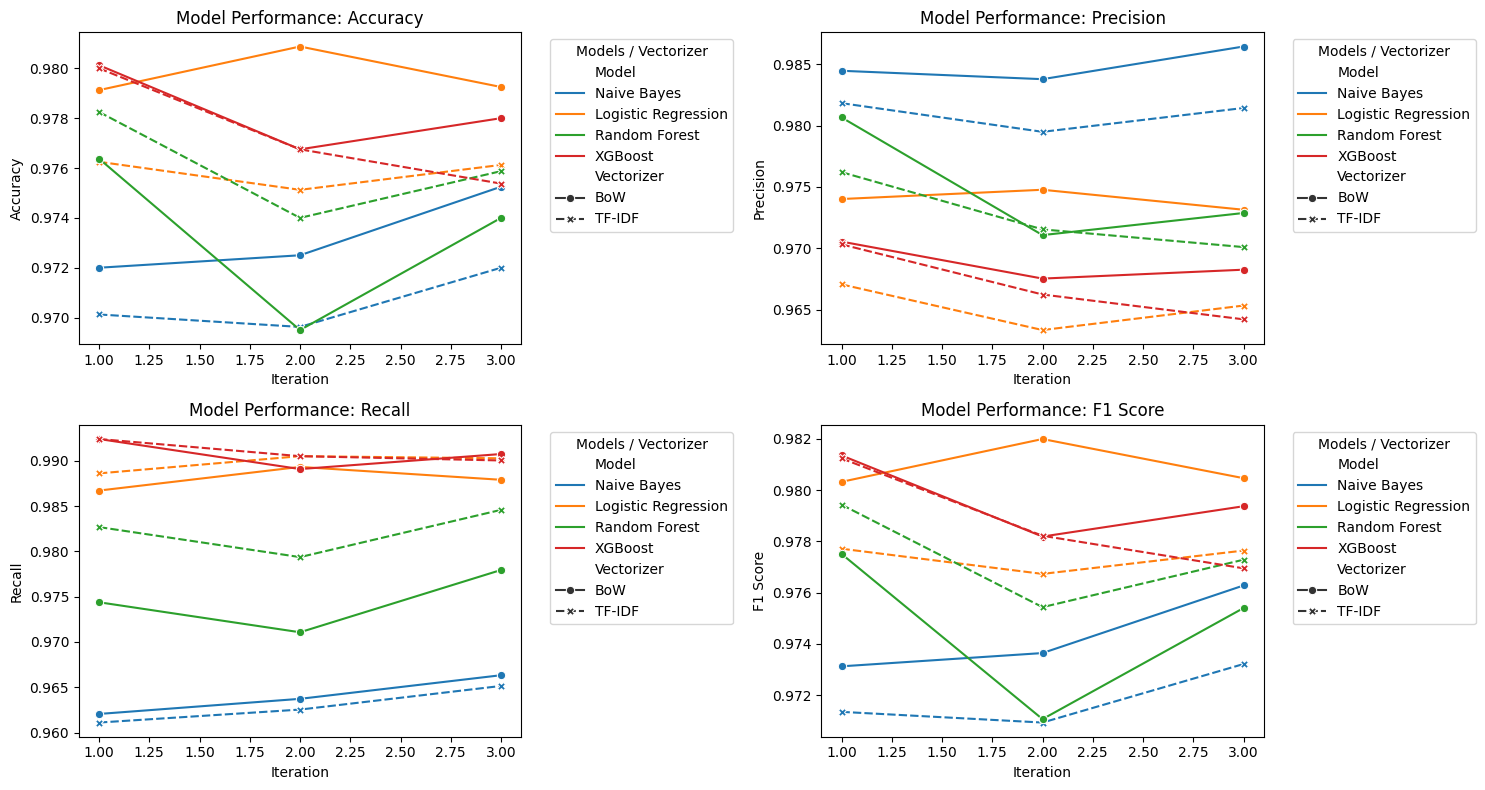

In [42]:
# Visualize the data iteration but exclude the metrics Mean
viz_result_metric( email_res[email_res['Iteration'] != 'Mean'])

I would also visualize the metrics mean for each of the metrics

In [43]:
def viz_result_metric_mean(data):
    mean_data = data[data['Iteration'] == 'Mean'].pivot(index='Vectorizer', columns='Model', values=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    plt.figure(figsize=(16, 10))

    metrics = mean_data.columns.levels[0]
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.heatmap(mean_data[metric], annot=True, fmt=".3f", linewidths=.5, cmap='coolwarm')
        plt.title(metric)
        plt.ylabel('Vectorizer')
        plt.xlabel('Model')

    plt.tight_layout()
    plt.show()

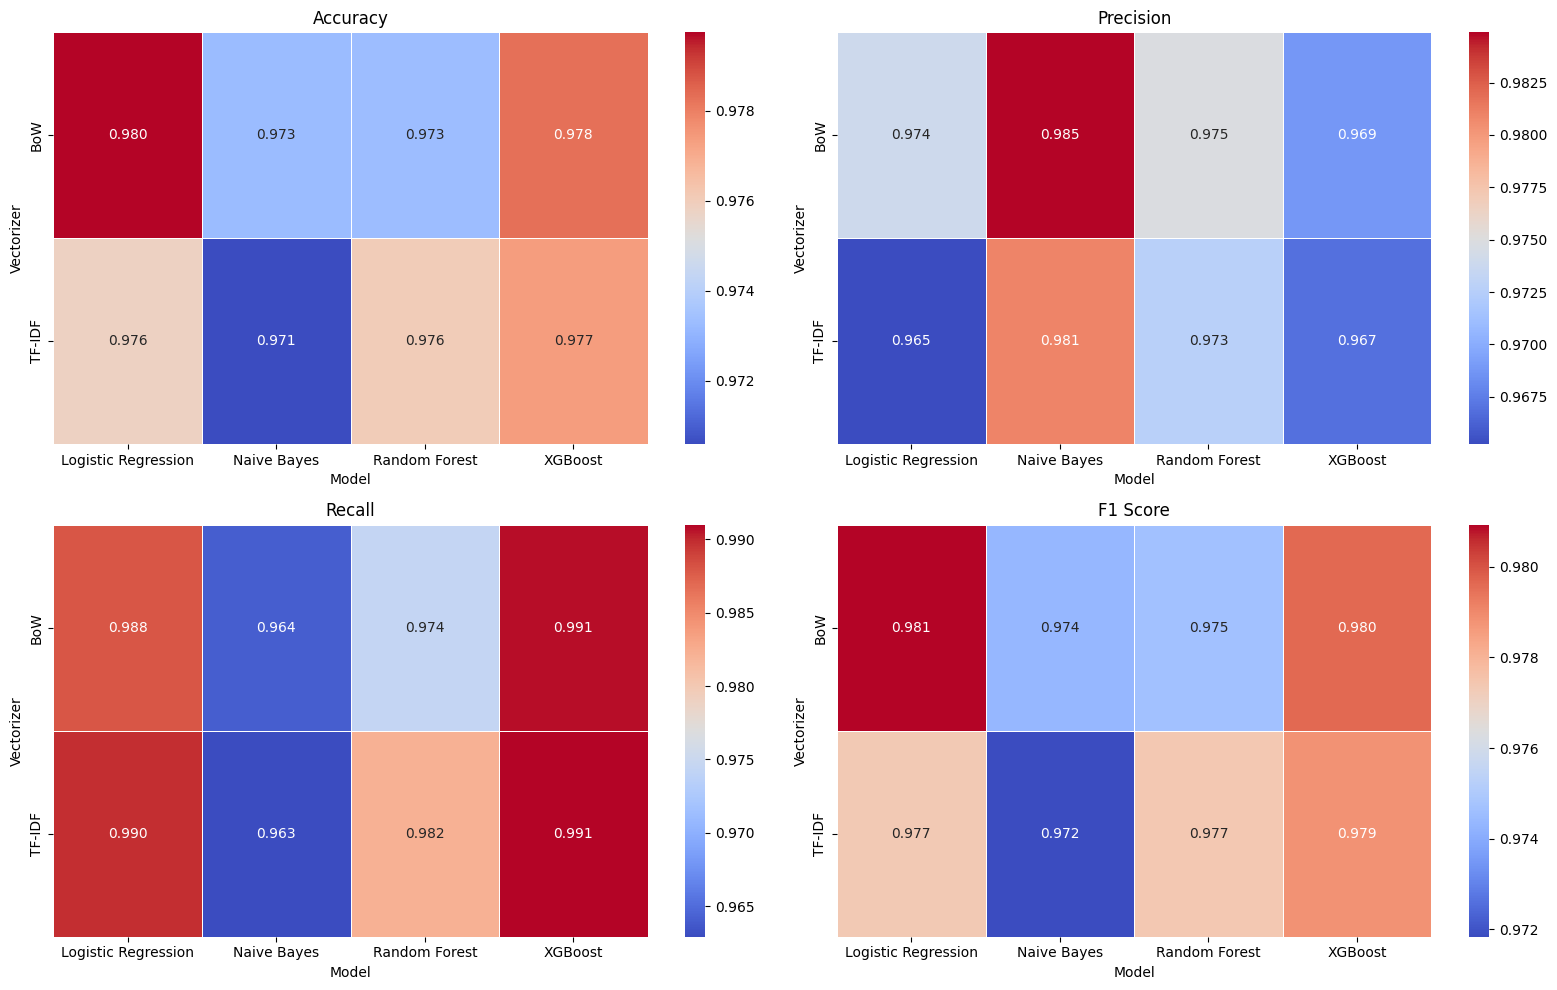

In [44]:
viz_result_metric_mean(email_res)

There are few important insight from our experiment with the original data, which are:

1. SVM might shown the worst performance with BoW vectorizer, but see a strong performance in the Accuracy and Recall metrics with the TF-IDF vectorizer.
2. Recall metrics shown more diverse result compared to the other metric, albeit not much.
3. Naive Bayes with BoW Vectorizer shown the best overall Precision metrics

In [45]:
email_res

,Iteration,Model,Vectorizer,Accuracy,Precision,Recall,F1 Score
0,1,Naive Bayes,BoW,0.972000,0.984466,0.962049,0.973129
1,2,Naive Bayes,BoW,0.972500,0.983781,0.963718,0.973646
2,3,Naive Bayes,BoW,0.975250,0.986444,0.966327,0.976282
3,Mean,Naive Bayes,BoW,0.973250,0.984897,0.964031,0.974352
4,1,Logistic Regression,BoW,0.979125,0.974011,0.986717,0.980323
5,2,Logistic Regression,BoW,0.980875,0.974766,0.989329,0.981994
6,3,Logistic Regression,BoW,0.979250,0.973137,0.987906,0.980466
7,Mean,Logistic Regression,BoW,0.979750,0.973971,0.987984,0.980927
8,1,Random Forest,BoW,0.976375,0.980664,0.974383,0.977513
9,2,Random Forest,BoW,0.969500,0.971069,0.971069,0.971069


The original data have already shown a great performance, which we would try in the test dataset. In this case, we would use the Naive Bayes in their default form.

### Final Training

In [46]:
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer()
naive_bayes_classifier = MultinomialNB()

# Creating a pipeline for the whole process
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', naive_bayes_classifier)
])

pipeline.fit(X_train['email'], y_train)


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [47]:
from sklearn.metrics import classification_report

y_pred = pipeline.predict(X_test['email'])
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2837
           1       0.98      0.96      0.97      3163

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



Even in their default form, the Naive Bayes shown a strong performance capability. Let's try how the performance with the special character and removing certain words.

In [48]:
email_res_sp = evaluate_models(X_train['email_remove_sp'], y_train)

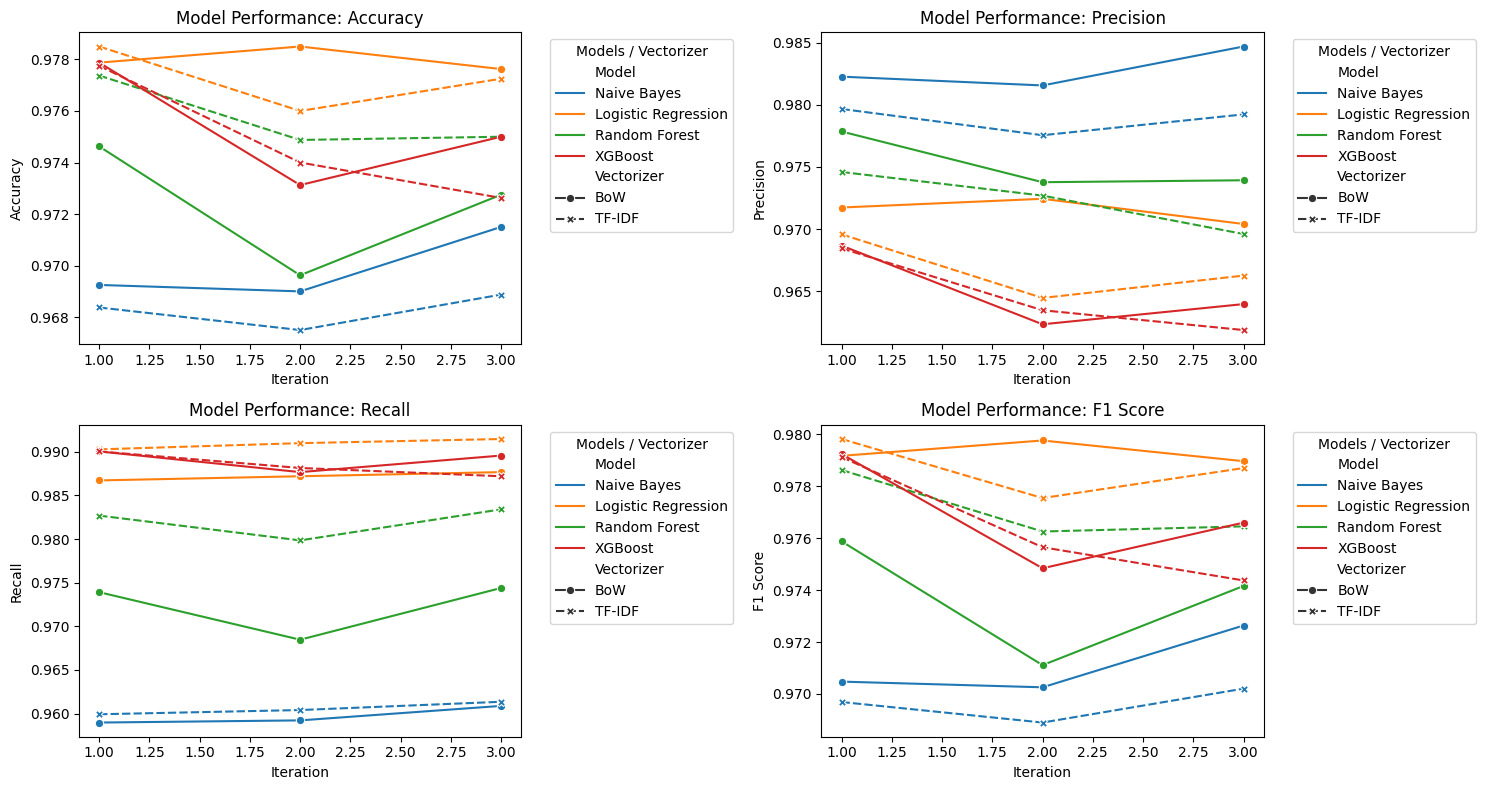

In [49]:
viz_result_metric( email_res_sp[email_res_sp['Iteration'] != 'Mean'])

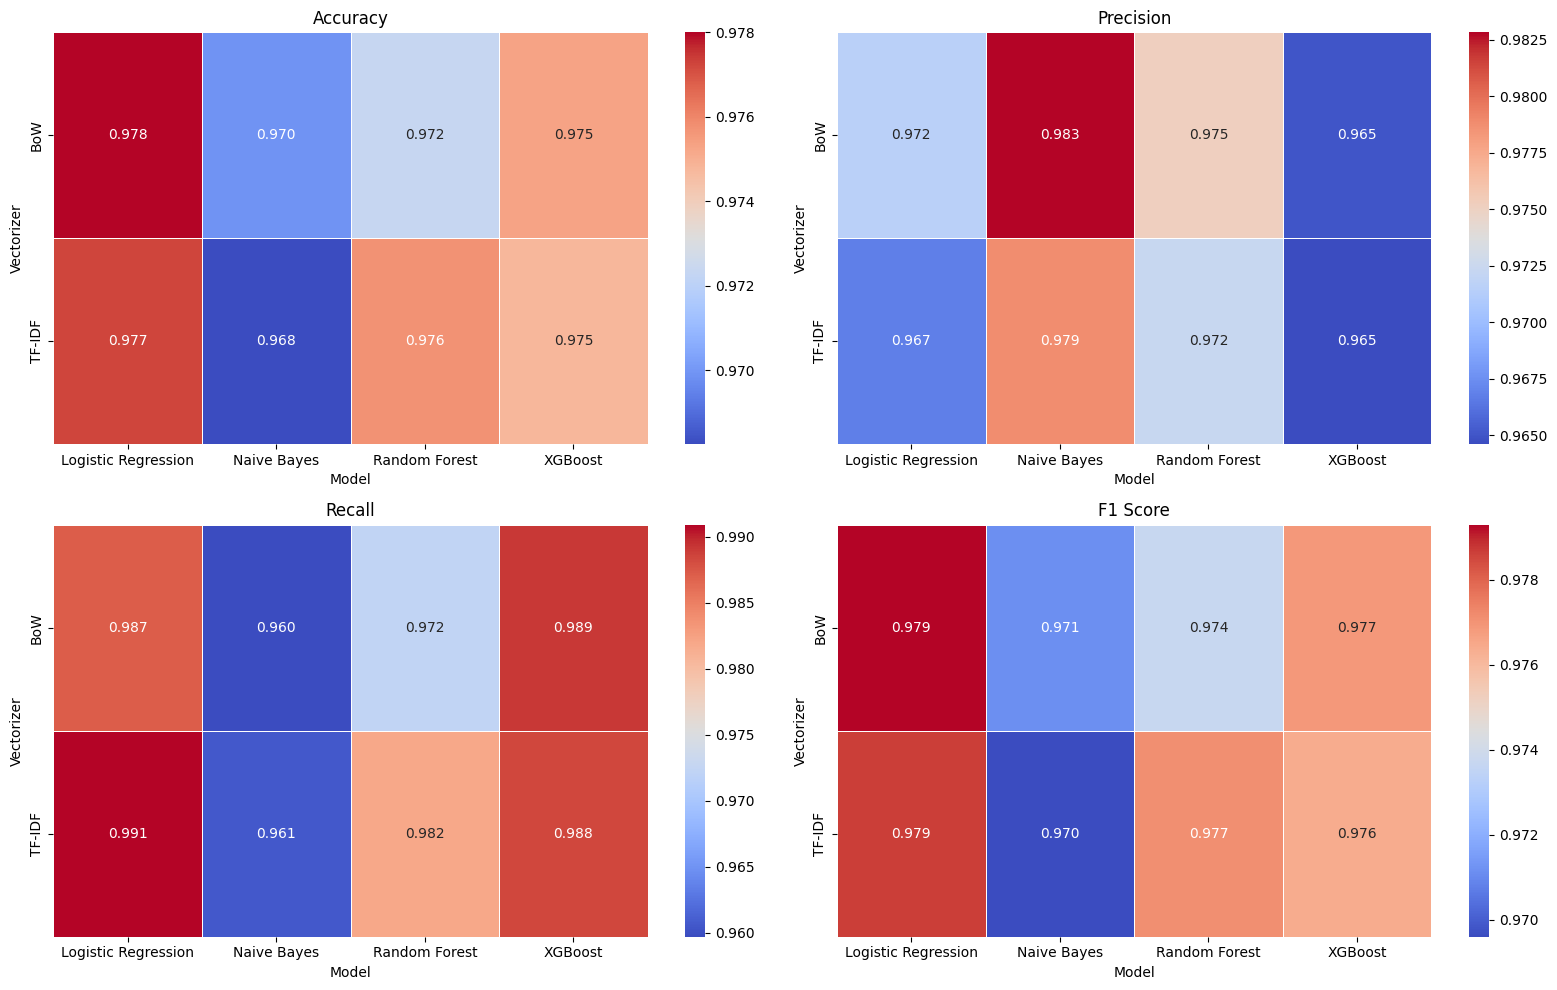

In [50]:
viz_result_metric_mean(email_res_sp)

There are no significant differences between model that trained in the original dataset and the removed character one. Let's test the model with the test data.

**Removed Special Character Model Training**

In [51]:
pipeline.fit(X_train['email_remove_sp'], y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [52]:
y_pred = pipeline.predict(X_test['email_remove_sp'])
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2837
           1       0.98      0.95      0.96      3163

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



The result shown not much significant change in the performance, rather the above result is slightly worse than the previous experiment. 

For the simplicity and based on the performance, I would train the model based on the original data and use that as basis for this model challange.

I would still provide the code for further experiment, but I would not process with that for now as the current result already shown a great performance.

**Model Generation**

In [53]:
pipeline.fit(df['email'], df['spam'])

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [54]:
import pickle

with open('spam_classifier_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [55]:
import pickle
filename = 'spam_classifier_pipeline.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)

In [ ]:
import pandas as pd
prediction = model.predict(pd.Series('This is email'))[0]

In [ ]:
import numpy as np
class_names = np.array(['Ham','Spam'])

In [ ]:
class_names[prediction]

In [ ]:
class_names